In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K

import numpy as np
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

In [5]:
saved_model_file = "keras2_mnist_cnn_allconv.h5"
model = keras.models.load_model(saved_model_file)
model.summary()
#[print(model.layers[i].output) for i in range(len(model.layers))]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_______________________________________

/Users/jsu/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test[:,:,:,None]
x_train = x_train[:,:,:,None]
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
batch_size = 128
num_classes = 10
epochs = 3

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    print(input_tensor.shape)
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    print(target_tensor.shape)
    xs = x_test
    ys = keras.utils.to_categorical(y_test, num_classes)
    print(x_test.shape)
    print(ys.shape)
    #attributions = {}
    attributions = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    attributions2 = de.explain('intgrad', target_tensor * ys, input_tensor, xs, steps=10)
    attributions3 = de.explain('integdeeplift', target_tensor * ys, input_tensor, xs, steps=10)

    #attributions = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print("Done!")

(?, 28, 28, 1)
(?, 10)
(10000, 28, 28, 1)
(10000, 10)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Done!


In [14]:
pre_softmax_output = K.function([model.layers[0].input],
                                  [model.layers[-2].output])

#pre_softmax_output([xs])
print(model.layers[0].input)
print(xs.shape)
results = pre_softmax_output([xs])[0]#np.array([pre_softmax_output(xs[i]) for i in range(len(xs))])
print(results.shape)
#print(np.argmax(ys, axis=1))
#print(results[np.argmax(ys, axis=1)])
results_indexed = [results[i][np.argmax(ys[i])] for i in range(len(ys))]
results_indexed = np.array(results_indexed)
print(results_indexed.shape)
#print(np.max(results, axis=1))
#print(np.argmin(results_indexed - np.max(results, axis=1)))

Tensor("conv2d_1_input:0", shape=(?, 28, 28, 1), dtype=float32)
(10000, 28, 28, 1)
(10000, 10)
(10000,)


In [12]:
print(attributions - results)

ValueError: operands could not be broadcast together with shapes (10000,28,28,1) (10000,10) 

In [16]:
diff1 = results_indexed - np.sum(attributions, axis=(1, 2, 3))
diff2 = results_indexed - np.sum(attributions2, axis=(1, 2, 3))
diff3 = results_indexed - np.sum(attributions3, axis=(1, 2, 3))

diff_deeplift = np.abs(diff1)
diff_intgrad_10 = np.abs(diff2)
diff_integdeeplift_10 = np.abs(diff3)

print(np.sum(diff_deeplift))
print(np.sum(diff_intgrad_10))
print(np.sum(diff_integdeeplift_10))

print(diff1[:100])
print(np.sum(attributions2) - np.sum(attributions))

1772.3252
9311.902935058475
19834.86818549343
[-0.24902344 -0.10351562 -0.12402344 -0.14111328 -0.2548828  -0.12451172
 -0.2548828   0.03686523 -0.0078125   0.03662109 -0.14257812 -0.3383789
  0.03662109 -0.14111328 -0.12451172 -0.00878906  0.03710938 -0.25
  0.02124023 -0.25390625  0.03759766 -0.33789062 -0.3383789  -0.0078125
 -0.25610352 -0.14208984 -0.24951172 -0.2553711  -0.1430664  -0.12402344
  0.02050781 -0.12353516  0.02099609 -0.2548828  -0.25048828 -0.10351562
 -0.25       -0.12402344 -0.1027832  -0.12451172 -0.1237793  -0.24951172
 -0.25439453 -0.10400391  0.02050781 -0.00927734 -0.12402344 -0.10302734
 -0.2553711  -0.25683594 -0.33789062  0.02099609 -0.0078125  -0.00927734
 -0.33935547 -0.14208984 -0.2553711  -0.12451172  0.03710938 -0.0090332
 -0.24902344  0.5019531   0.03686523  0.02148438 -0.2475586  -0.2553711
 -0.3383789  -0.2548828   0.02001953 -0.14208984 -0.25       -0.14160156
 -0.10302734  0.03686523 -0.12451172 -0.24902344  0.02246094 -0.10253906
  0.03686523 -0

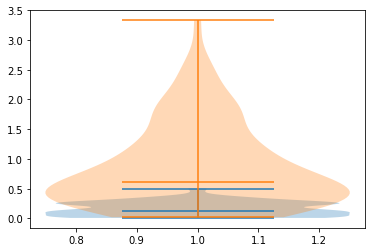

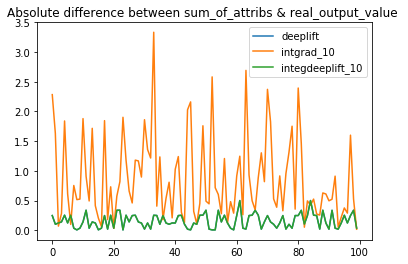

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.violinplot(diff_deeplift[:100], showmedians=True)
plt.violinplot(diff_intgrad_10[:100], showmedians=True)
#plt.violinplot(diff_integdeeplift_10[:100], showmedians=True)
plt.show()
plt.plot(diff_deeplift[:100], label="deeplift", )
plt.plot(diff_intgrad_10[:100], label="intgrad_10")
plt.plot(diff_integdeeplift_10[:100], label="integdeeplift_10")
plt.legend()
plt.title("Absolute difference between sum_of_attribs & real_output_value ")
plt.show()
